**Model_1: adding some Non-Linearity**

In [2]:
# setting up train test data
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data=datasets.FashionMNIST(
    root='data',
    train=True,
    download=False,
    transform=ToTensor(),
    target_transform=None
)


test_data=datasets.FashionMNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download=False    
)

In [ ]:
image,labels=train_data[0]

9


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

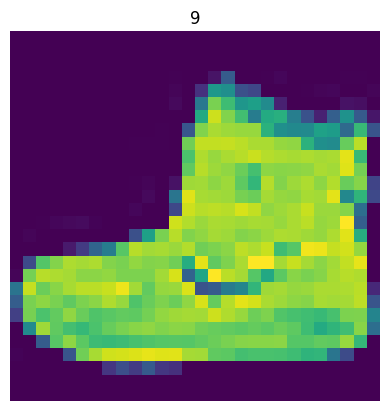

In [6]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze())
plt.title(label=labels)
plt.axis(False)

In [7]:
# class names of training dataset
class_names=train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [9]:
print(len(train_data.targets))
print(len(train_data.data))
print(len(test_data.targets))
print(len(test_data.data))

60000
60000
10000
10000


In [39]:
# for working with models, we'll use dataloader
from torch.utils.data import DataLoader
BATCH_SIZE=32

train_dataloader=DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader=DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False)

In [40]:
# EXAMPLE, what Dataloader contains
train_feature_batch, train_labels_batch=next(iter(train_dataloader))
print(train_feature_batch.shape)
print(train_labels_batch)

torch.Size([32, 1, 28, 28])
tensor([2, 7, 9, 4, 8, 7, 7, 1, 0, 6, 4, 6, 3, 6, 8, 9, 9, 7, 1, 5, 1, 5, 2, 6,
        4, 5, 9, 9, 8, 4, 5, 2])


In [19]:
# setting device
import torch
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [64]:
# model_1 building
from torch import nn
class FashionMNISTV1(nn.Module):
    def __init__(self, input_layer:int, output_layer:int, hidden_layer:int):
        super().__init__()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_layer, out_features=hidden_layer),
            nn.ReLU(), # Activation Function
            nn.Linear(in_features=hidden_layer, out_features=output_layer),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.layer_stack(x)


In [65]:
model_1=FashionMNISTV1(input_layer=784,hidden_layer=10,output_layer=len(class_names))
model_1.to(device)



FashionMNISTV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [66]:
# loss function, optimization
loss_fn=nn.CrossEntropyLoss()
optimization=torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [67]:
# accuracy function
from helper_functions import accuracy_fn

*Functionalizing Train Loop*

In [71]:
def training_loop(model:nn.Module,
                 data_loader:torch.utils.data.DataLoader,
                 loss_fn:nn.modules,
                 accuracy_fn,
                 optimizer:torch.optim.Optimizer,
                 device:torch.device=device):
    train_loss=0
    train_acc=0
    for batch,(X,y) in enumerate(data_loader):
    
        # into device CPU
        X=X.to(device)
        y=y.to(device)

        model.train() # train
        y_pred=model(X) # forward pass
        loss=loss_fn(y_pred, y) # loss
        train_loss+=loss  # train loss
        train_acc+=accuracy_fn(y,y_pred.argmax(dim=1)) # train accuracy
        optimizer.zero_grad() # zero grad
        loss.backward() # backward propagation
        optimizer.step() # updation
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


*Functionalizing Testing Loop*

In [72]:
def testing_loop(model:nn.Module,
                 data_loader:torch.utils.data.DataLoader,
                 loss_fn:nn.Module,
                 accuracy_fn,
                 device:torch.device=device
                 ):
    test_loss,test_acc=0,0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X=X.to(device)
            y=y.to(device)
            test_pred=model(X) # forward pass
            test_loss+=loss_fn(test_pred,y)
            test_acc+=accuracy_fn(y,test_pred.argmax(dim=1))
        test_loss/=len(data_loader)
        test_acc/=len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

*Training Testing Model*

In [ ]:
torch.manual_seed(42)
epochs=3
# from tqdm.auto import tqdm

for epoch in (range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    training_loop(model=model_1,data_loader=train_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,optimizer=optimization,device=device)
    testing_loop(model=model_1,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,device=device)
    

Epoch: 0
---------
Train loss: 0.43206 | Train accuracy: 84.54%
Test loss: 0.43956 | Test accuracy: 84.34%

Epoch: 1
---------
Train loss: 0.41945 | Train accuracy: 84.94%
Test loss: 0.45322 | Test accuracy: 83.59%

Epoch: 2
---------
Train loss: 0.40758 | Train accuracy: 85.47%
Test loss: 0.43578 | Test accuracy: 84.63%



*model_1 evaluation*

In [75]:
torch.manual_seed(42)


def model_evaluation(model: torch.nn.Module,
                     data_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     accuracy_fn):

    loss = 0
    acc = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            model_pred = model(X)
            loss += loss_fn(model_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=model_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,  # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [76]:
model_1_performance=model_evaluation(model=model_1,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
print(model_1_performance)




{'model_name': 'FashionMNISTV1', 'model_loss': 0.4357796907424927, 'model_acc': 84.63458466453675}
